In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow

In [3]:
import os

print("Weights:", os.path.exists("/content/yolov7.weights"))
print("Config:", os.path.exists("/content/yolov7.cfg"))
print("Labels:", os.path.exists("/content/coco.names"))
print("Video:", os.path.exists("/content/cycling.mp4"))


Weights: True
Config: True
Labels: True
Video: True


In [13]:
class YOLOv7VideoDetection:
    def __init__(self, video_path):
        self.video_path = video_path
        self.results = {}  # store frame-wise detections

    def load_model(self):
        net = cv2.dnn.readNet("/content/yolov7.weights", "/content/yolov7.cfg")
        if cv2.cuda.getCudaEnabledDeviceCount() > 0:
            print("✅ CUDA available — using GPU for inference.")
            net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
            net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        else:
            print("⚙️ CUDA not found — using CPU.")
            net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
            net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

        with open("/content/coco.names", "r") as f:
            classes = [line.strip() for line in f.readlines()]

        output_layers = net.getUnconnectedOutLayersNames()
        colors = np.random.uniform(0, 255, size=(len(classes), 3))
        return net, classes, colors, output_layers

    def detect_objects(self, img, net, output_layers):
        blob = cv2.dnn.blobFromImage(img, 0.00392, (320, 320), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        return net.forward(output_layers)

    def get_box_dimensions(self, outputs, height, width):
        boxes, confs, class_ids = [], [], []
        for output in outputs:
            for detect in output:
                scores = detect[5:]
                class_id = np.argmax(scores)
                conf = scores[class_id]
                if conf > 0.5:  # confidence threshold
                    center_x, center_y = int(detect[0] * width), int(detect[1] * height)
                    w, h = int(detect[2] * width), int(detect[3] * height)
                    x, y = int(center_x - w / 2), int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confs.append(float(conf))
                    class_ids.append(class_id)
        return boxes, confs, class_ids

    def draw_labels(self, boxes, confs, colors, class_ids, classes, img, frame_count=None):
        indexes = cv2.dnn.NMSBoxes(boxes, confs, 0.5, 0.5)  # NMS threshold
        font = cv2.FONT_HERSHEY_SIMPLEX
        frame_results = []

        for i in range(len(boxes)):
            if i in indexes:
                x, y, w, h = boxes[i]
                label = str(classes[class_ids[i]])
                confidence = confs[i]
                color = colors[class_ids[i] % len(colors)]
                cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
                cv2.putText(img, f"{label} {confidence:.2f}", (x, y - 5), font, 0.6, color, 2)
                frame_results.append({
                    "class": label,
                    "confidence": float(confidence),
                    "bbox": [x, y, w, h]
                })

        if frame_count is not None:
            self.results[frame_count] = frame_results

    def start_video(self):
        net, classes, colors, output_layers = self.load_model()

        if not os.path.exists(self.video_path):
            print(f"❌ Error: {self.video_path} not found.")
            return

        cap = cv2.VideoCapture(self.video_path)
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                print("✅ Video ended.")
                break

            frame_count += 1
            height, width, _ = frame.shape
            outputs = self.detect_objects(frame, net, output_layers)
            boxes, confs, class_ids = self.get_box_dimensions(outputs, height, width)
            self.draw_labels(boxes, confs, colors, class_ids, classes, frame, frame_count)

            # ---- Print detections per frame ----
            print(f"\n🟩 Frame {frame_count} detections:")
            for det in self.results[frame_count]:
                print(f"- Detected {det['class']}: {det['confidence']:.2f}")

            cv2_imshow(frame)
            if cv2.waitKey(1) & 0xFF == 27:
                break

        cap.release()
        cv2.destroyAllWindows()
        print("\n📊 All detection results stored in `detector.results`")


⚙️ CUDA not found — using CPU.

🟩 Frame 1 detections:
- Detected bicycle: 0.64
- Detected person: 0.84
- Detected bicycle: 0.65
- Detected person: 0.80
- Detected person: 0.88
- Detected bicycle: 0.91


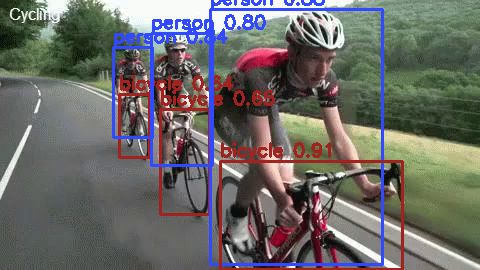


🟩 Frame 2 detections:
- Detected bicycle: 0.64
- Detected person: 0.84
- Detected bicycle: 0.64
- Detected person: 0.80
- Detected person: 0.89
- Detected bicycle: 0.91


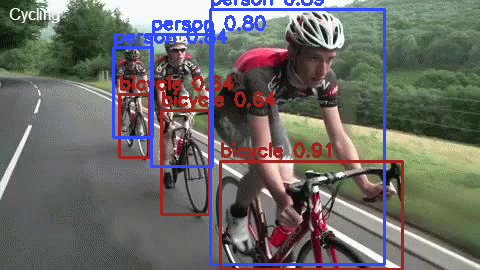


🟩 Frame 3 detections:
- Detected person: 0.78
- Detected person: 0.83
- Detected bicycle: 0.51
- Detected bicycle: 0.70
- Detected person: 0.91
- Detected bicycle: 0.90


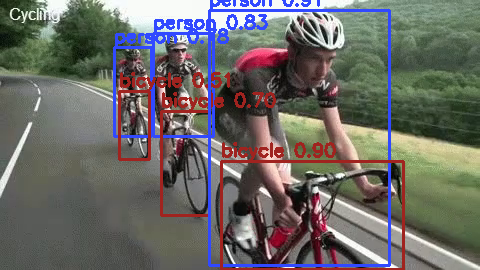


🟩 Frame 4 detections:
- Detected person: 0.77
- Detected person: 0.81
- Detected bicycle: 0.56
- Detected bicycle: 0.75
- Detected person: 0.92
- Detected bicycle: 0.91


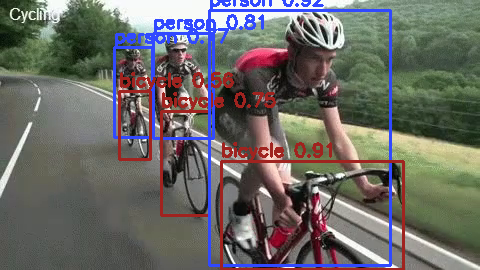


🟩 Frame 5 detections:
- Detected backpack: 0.56
- Detected bicycle: 0.65
- Detected person: 0.73
- Detected person: 0.89
- Detected bicycle: 0.79
- Detected person: 0.92
- Detected bicycle: 0.81


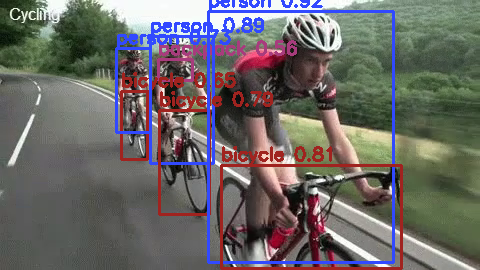


🟩 Frame 6 detections:
- Detected backpack: 0.61
- Detected bicycle: 0.66
- Detected person: 0.71
- Detected person: 0.86
- Detected person: 0.92
- Detected bicycle: 0.79
- Detected bicycle: 0.83


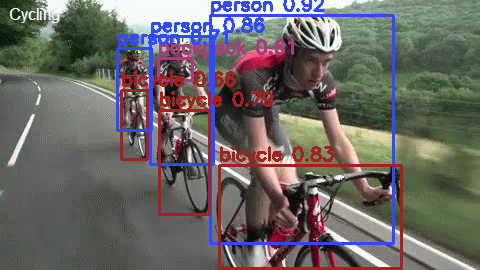


🟩 Frame 7 detections:
- Detected person: 0.71
- Detected person: 0.79
- Detected bicycle: 0.71
- Detected person: 0.91
- Detected bicycle: 0.82


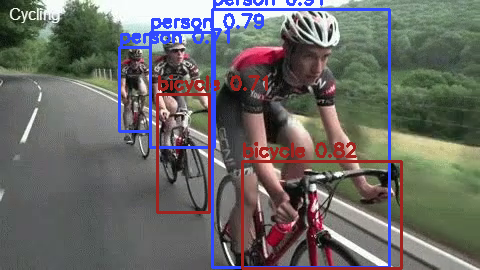


🟩 Frame 8 detections:
- Detected backpack: 0.52
- Detected person: 0.72
- Detected person: 0.80
- Detected bicycle: 0.72
- Detected person: 0.91
- Detected bicycle: 0.81


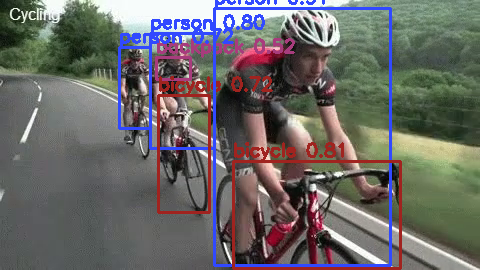


🟩 Frame 9 detections:
- Detected person: 0.62
- Detected bicycle: 0.74
- Detected person: 0.76
- Detected person: 0.92
- Detected bicycle: 0.86


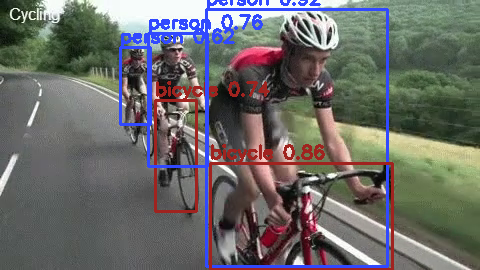


🟩 Frame 10 detections:
- Detected person: 0.70
- Detected person: 0.68
- Detected bicycle: 0.85
- Detected person: 0.91


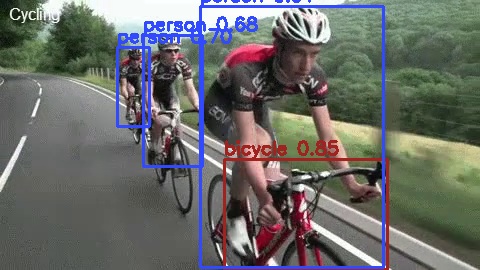


🟩 Frame 11 detections:
- Detected person: 0.67
- Detected person: 0.71
- Detected bicycle: 0.50
- Detected bicycle: 0.85
- Detected person: 0.90


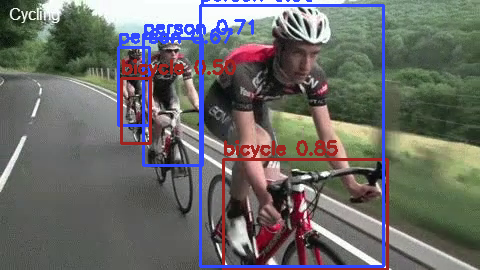


🟩 Frame 12 detections:
- Detected person: 0.86
- Detected bicycle: 0.63
- Detected person: 0.91
- Detected bicycle: 0.89


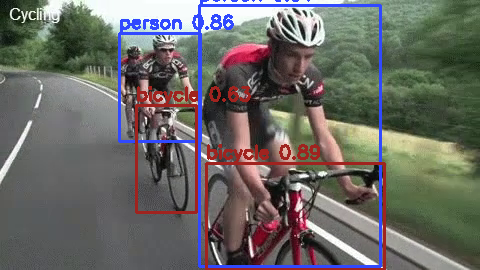


🟩 Frame 13 detections:
- Detected person: 0.87
- Detected bicycle: 0.58
- Detected bicycle: 0.91
- Detected person: 0.91


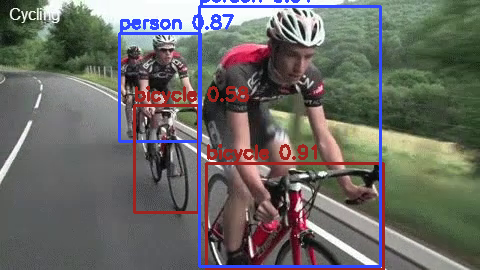


🟩 Frame 14 detections:
- Detected person: 0.69
- Detected bicycle: 0.79
- Detected person: 0.92
- Detected bicycle: 0.85


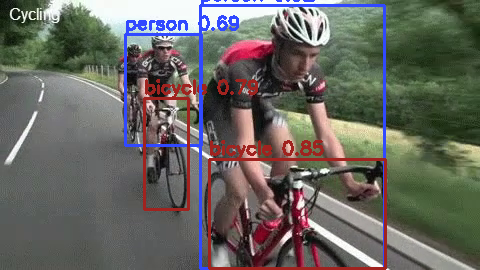


🟩 Frame 15 detections:
- Detected person: 0.67
- Detected bicycle: 0.80
- Detected person: 0.92
- Detected bicycle: 0.85


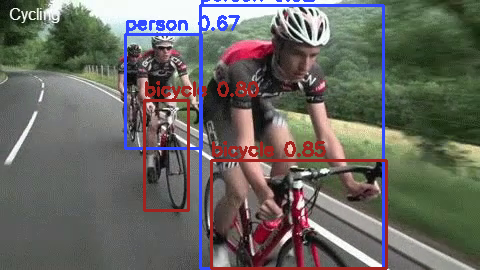


🟩 Frame 16 detections:
- Detected person: 0.61
- Detected person: 0.58
- Detected bicycle: 0.76
- Detected bicycle: 0.88
- Detected person: 0.81


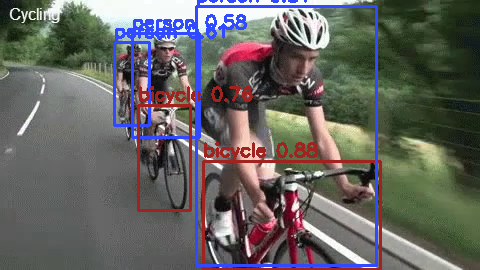


🟩 Frame 17 detections:
- Detected person: 0.61
- Detected person: 0.56
- Detected person: 0.78
- Detected bicycle: 0.76
- Detected bicycle: 0.91


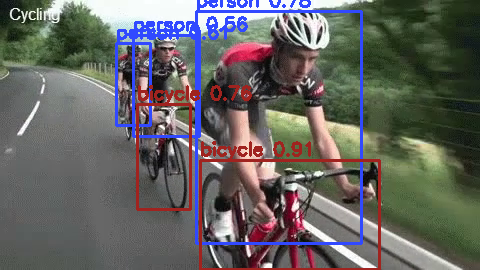


🟩 Frame 18 detections:
- Detected person: 0.51
- Detected person: 0.75
- Detected bicycle: 0.61
- Detected person: 0.86
- Detected bicycle: 0.91


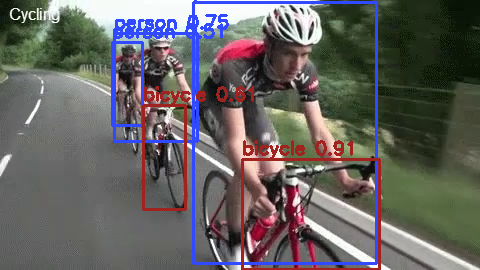


🟩 Frame 19 detections:
- Detected person: 0.75
- Detected bicycle: 0.79
- Detected person: 0.91
- Detected bicycle: 0.89


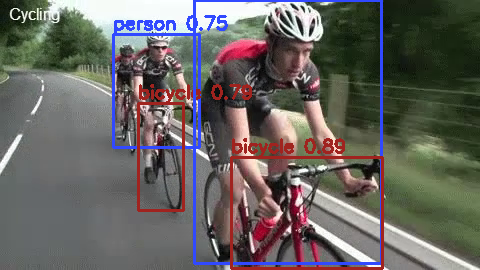


🟩 Frame 20 detections:
- Detected person: 0.73
- Detected bicycle: 0.82
- Detected person: 0.90
- Detected bicycle: 0.88


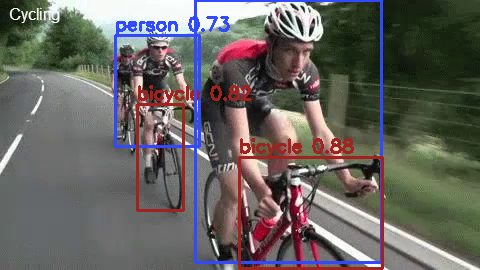


🟩 Frame 21 detections:
- Detected person: 0.71
- Detected person: 0.72
- Detected bicycle: 0.78
- Detected bicycle: 0.90
- Detected person: 0.86


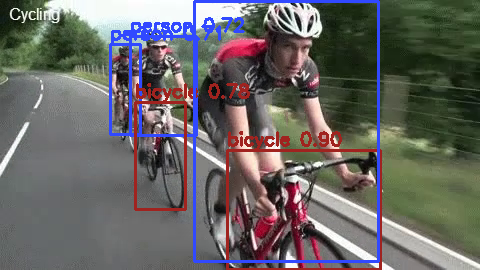


🟩 Frame 22 detections:
- Detected person: 0.69
- Detected person: 0.67
- Detected bicycle: 0.71
- Detected bicycle: 0.90
- Detected person: 0.85


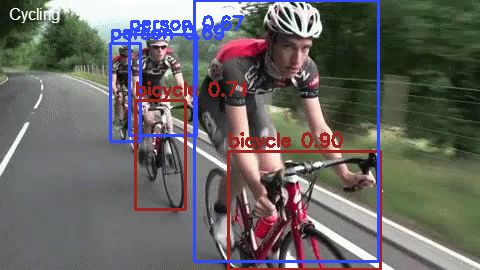


🟩 Frame 23 detections:
- Detected person: 0.65
- Detected bicycle: 0.65
- Detected bicycle: 0.90
- Detected person: 0.82
- Detected person: 0.88


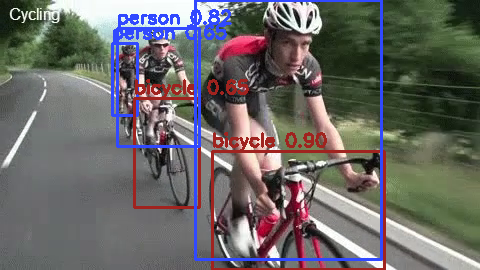


🟩 Frame 24 detections:
- Detected person: 0.64
- Detected bicycle: 0.66
- Detected bicycle: 0.91
- Detected person: 0.85
- Detected person: 0.86


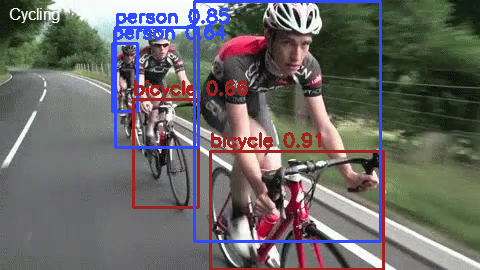


🟩 Frame 25 detections:
- Detected person: 0.60
- Detected bicycle: 0.83
- Detected person: 0.83
- Detected person: 0.91
- Detected bicycle: 0.90


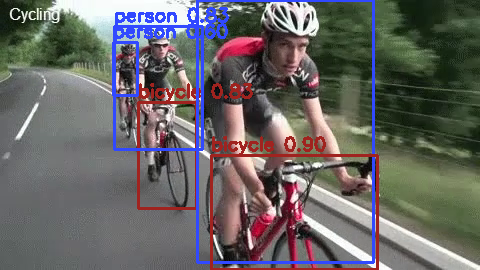


🟩 Frame 26 detections:
- Detected person: 0.67
- Detected bicycle: 0.82
- Detected person: 0.81
- Detected person: 0.91
- Detected bicycle: 0.91


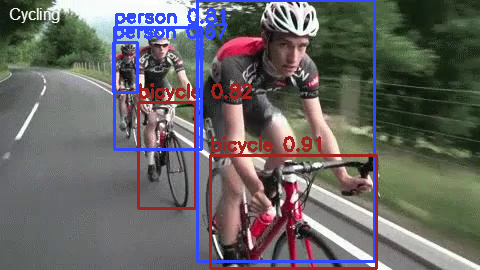


🟩 Frame 27 detections:
- Detected bicycle: 0.69
- Detected person: 0.77
- Detected person: 0.88
- Detected bicycle: 0.89


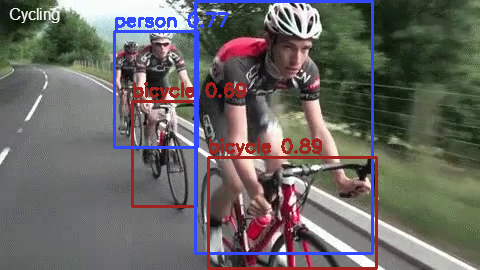


🟩 Frame 28 detections:
- Detected person: 0.80
- Detected bicycle: 0.60
- Detected bicycle: 0.95
- Detected person: 0.92


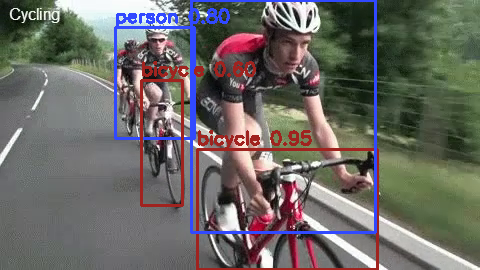


🟩 Frame 29 detections:
- Detected person: 0.80
- Detected bicycle: 0.63
- Detected bicycle: 0.95
- Detected person: 0.92


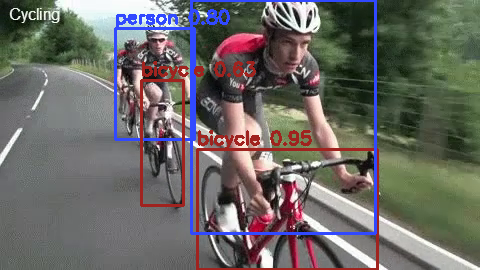


🟩 Frame 30 detections:
- Detected bicycle: 0.77
- Detected person: 0.87
- Detected person: 0.93
- Detected bicycle: 0.90


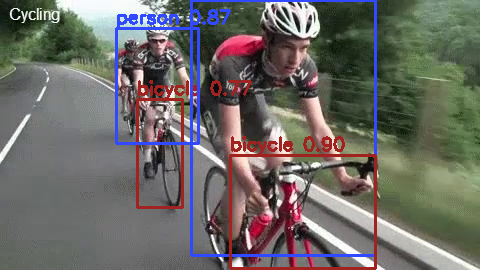

✅ Video ended.

📊 All detection results stored in `detector.results`


In [14]:
video_path = "/content/cycling.mp4"
detector = YOLOv7VideoDetection(video_path)
detector.start_video()


In [21]:
import pandas as pd


In [22]:
all_data = []
for frame, detections in detector.results.items():
    for det in detections:
        all_data.append({
            "Frame": frame,
            "Class": det["class"],
            "Confidence": det["confidence"]
        })

In [23]:
df = pd.DataFrame(all_data)
df  # Display frame-wise class confidence table


Frame    Class  Confidence
0        1  bicycle    0.642004
1        1   person    0.842809
2        1  bicycle    0.647963
3        1   person    0.797784
4        1   person    0.882878
..     ...      ...         ...
143     29   person    0.919875
144     30  bicycle    0.765484
145     30   person    0.871285
146     30   person    0.932726
147     30  bicycle    0.895661

[148 rows x 3 columns]

In [24]:
df_pivot = df.pivot_table(index='Frame', columns='Class', values='Confidence', fill_value=0)
df_pivot

Class  backpack   bicycle    person
Frame                              
1      0.000000  0.733954  0.841157
2      0.000000  0.729962  0.842451
3      0.000000  0.703802  0.841020
4      0.000000  0.741668  0.833422
5      0.556091  0.752925  0.847249
6      0.614715  0.756249  0.827388
7      0.000000  0.764117  0.803043
8      0.519317  0.764899  0.810364
9      0.000000  0.799069  0.766540
10     0.000000  0.849954  0.760483
11     0.000000  0.674854  0.761041
12     0.000000  0.759483  0.885814
13     0.000000  0.747467  0.889271
14     0.000000  0.821927  0.804581
15     0.000000  0.822251  0.797120
16     0.000000  0.815924  0.666392
17     0.000000  0.835749  0.649952
18     0.000000  0.759166  0.707734
19     0.000000  0.840164  0.827968
20     0.000000  0.852615  0.819630
21     0.000000  0.838672  0.764274
22     0.000000  0.801475  0.737974
23     0.000000  0.777538  0.784703
24     0.000000  0.782137  0.783398
25     0.000000  0.867998  0.780259
26     0.000000  0.865498  0.795075
27     0.000000  0.791965  0.822909
28     0.000000  0.776289  0.859675
29     0.000000  0.790526  0.862188
30     0.000000  0.830573  0.902006

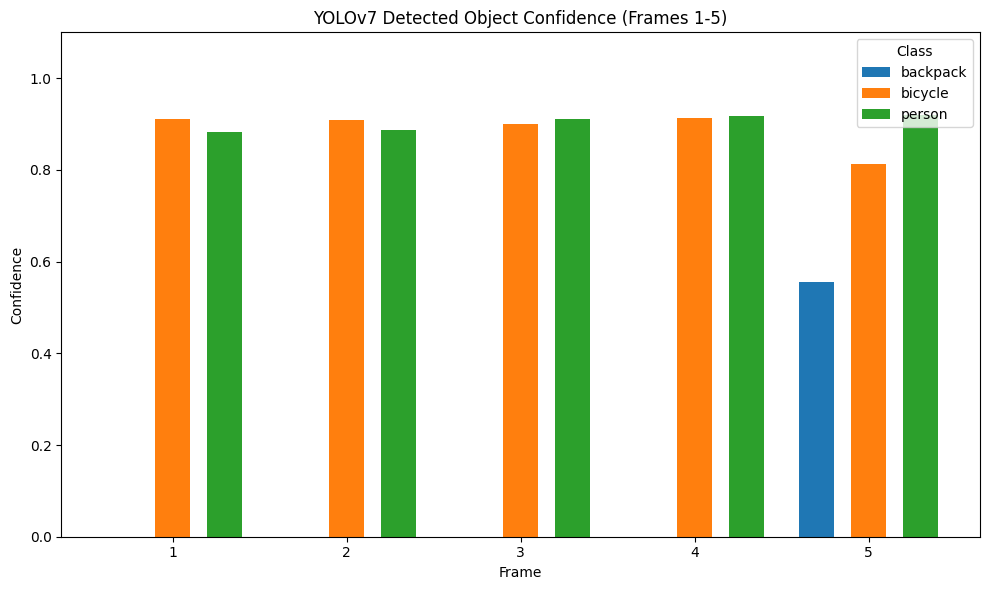

Frame 1 detections: bicycle (0.91), person (0.88)
Frame 2 detections: bicycle (0.91), person (0.89)
Frame 3 detections: person (0.91), bicycle (0.90)
Frame 4 detections: person (0.92), bicycle (0.91)
Frame 5 detections: backpack (0.56), bicycle (0.81), person (0.92)


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Frames to plot
frames_to_plot = list(range(1,6))

# Collect all classes across these frames
all_classes = set()
for frame in frames_to_plot:
    if frame in detector.results:
        all_classes.update([det['class'] for det in detector.results[frame]])
all_classes = sorted(list(all_classes))  # consistent order

# Prepare data for clustered bar chart
frame_indices = np.arange(len(frames_to_plot))
bar_width = 0.2  # width of each bar
offsets = np.linspace(-bar_width*len(all_classes)/2, bar_width*len(all_classes)/2, len(all_classes))

plt.figure(figsize=(10,6))

# Plot bars for each class
for i, cls in enumerate(all_classes):
    confidences = []
    for frame in frames_to_plot:
        # Get max confidence for this class in this frame
        if frame in detector.results:
            frame_dets = [det['confidence'] for det in detector.results[frame] if det['class'] == cls]
            max_conf = max(frame_dets) if frame_dets else 0
        else:
            max_conf = 0
        confidences.append(max_conf)
    plt.bar(frame_indices + offsets[i], confidences, width=bar_width, label=cls)

# Labels and title
plt.xlabel("Frame")
plt.ylabel("Confidence")
plt.title("YOLOv7 Detected Object Confidence (Frames 1-5)")
plt.xticks(frame_indices, [str(f) for f in frames_to_plot])
plt.ylim(0,1.1)
plt.legend(title="Class")
plt.tight_layout()
plt.show()

# -------------------
# Print description per frame
# -------------------
for frame in frames_to_plot:
    if frame not in detector.results:
        continue
    frame_dets = detector.results[frame]
    desc = f"Frame {frame} detections: "
    cls_max = {}
    for det in frame_dets:
        cls = det['class']
        cls_max[cls] = max(cls_max.get(cls, 0), det['confidence'])
    desc += ", ".join([f"{cls} ({conf:.2f})" for cls, conf in cls_max.items()])
    print(desc)


In [27]:
# -------------------------------
# Final Detection Summary
# -------------------------------

final_classes = {}
for frame, detections in detector.results.items():
    for det in detections:
        cls = det['class']
        conf = det['confidence']
        # Take max confidence per class
        if cls not in final_classes or conf > final_classes[cls]:
            final_classes[cls] = conf

print("✅ Final Detected Objects Across All Frames:")
for cls, conf in final_classes.items():
    print(f"- {cls}: {conf:.2f}")


✅ Final Detected Objects Across All Frames:
- bicycle: 0.95
- person: 0.93
- backpack: 0.61
